In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation
from keras import regularizers
import keras
import tensorflow as tf
import os


In [2]:
train_path = os.path.join(".", "rice_leaf", "train")
test_path = os.path.join(".", "rice_leaf", "validation")

In [3]:
image_train_gen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.3,
                                     rotation_range=90,
                                     width_shift_range=0.2, 
                                     height_shift_range=0.2,
                                     shear_range=0.2, 
                                     horizontal_flip=True,
                                     fill_mode='nearest')

train_data_gen = image_train_gen.flow_from_directory(train_path,
                                                     shuffle=True,
                                                     batch_size=64,
                                                     target_size=(300,300),
                                                     class_mode='categorical')

img_val_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = img_val_gen.flow_from_directory(test_path,
                                               batch_size=64,
                                               target_size=(300,300),
                                               class_mode='categorical')

Found 2519 images belonging to 7 classes.
Found 350 images belonging to 7 classes.


In [4]:
import matplotlib.pyplot as plt
def plotImages(image_arr):
    fig,axes = plt.subplots(5, 5, figsize=(20,20))
    axes = axes.flatten()
    for img,ax in zip(image_arr,axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

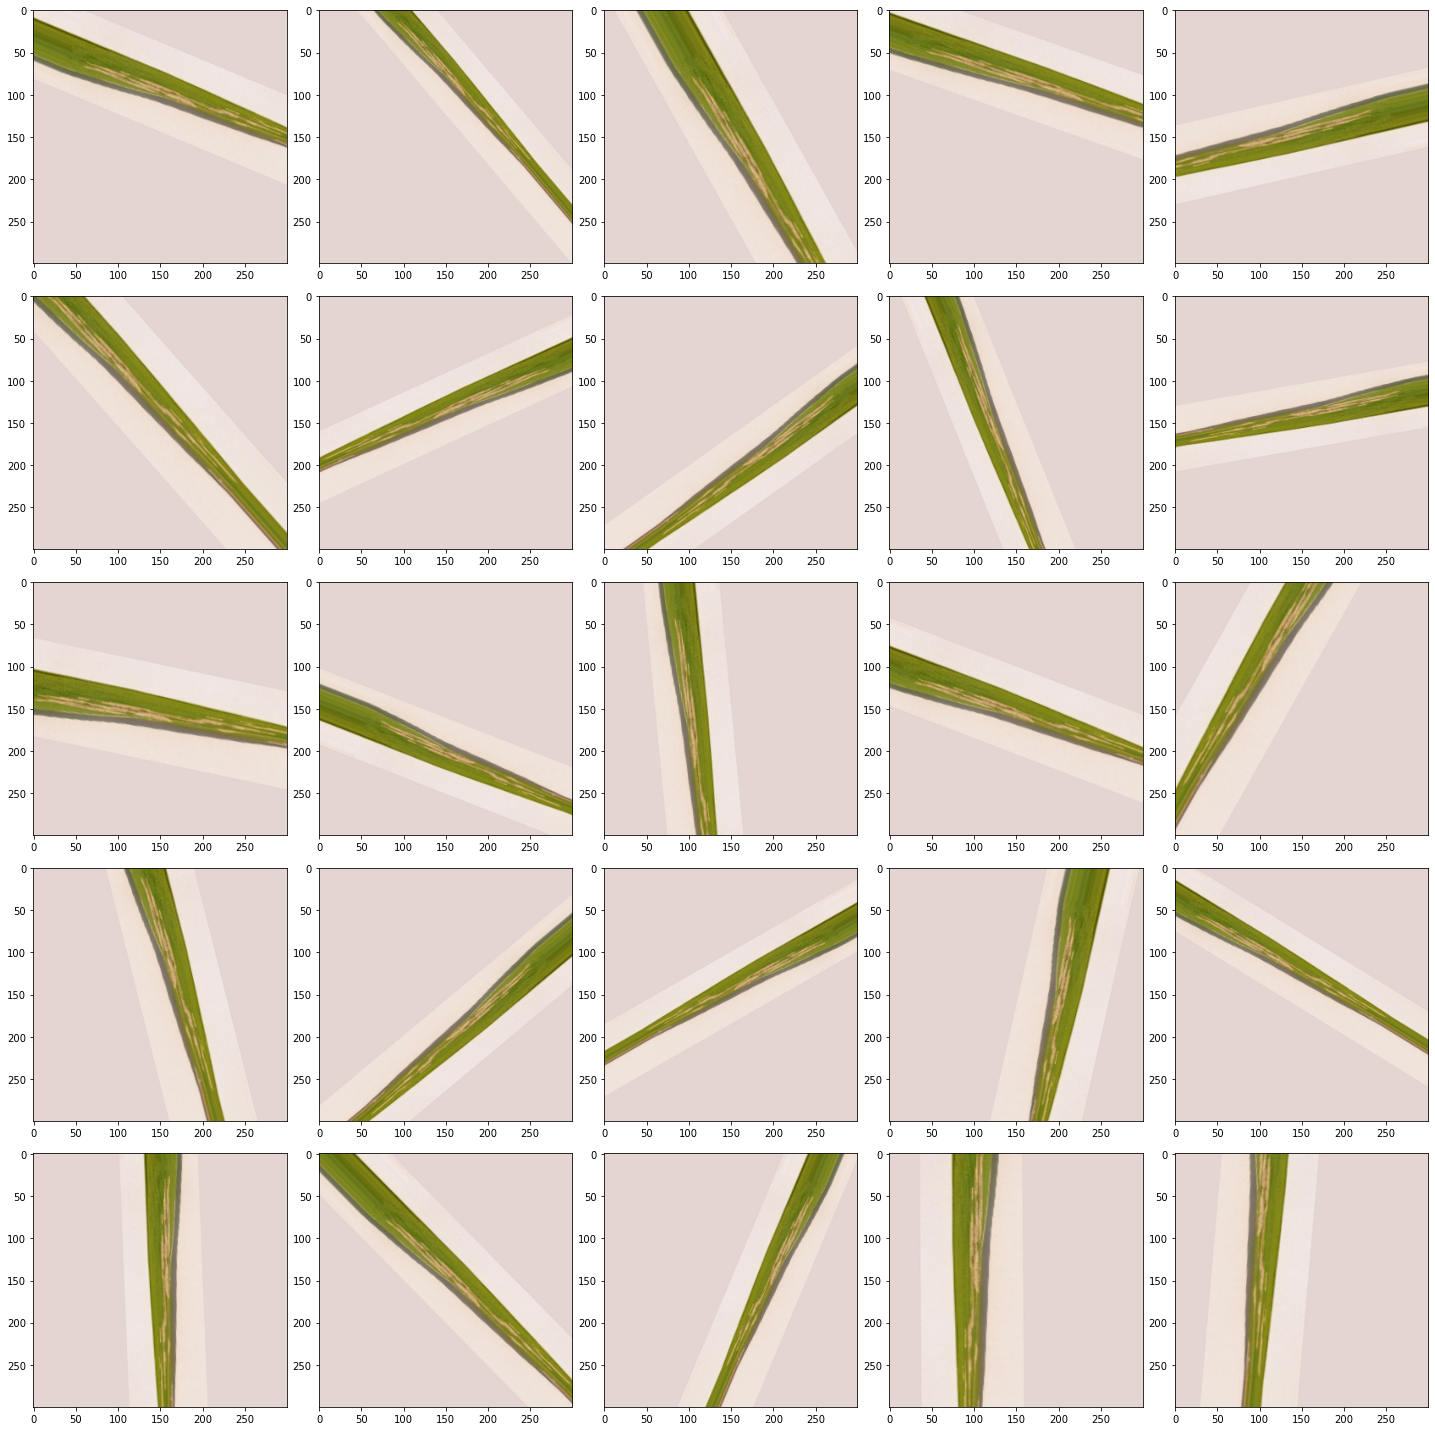

In [5]:
img_array = [train_data_gen[0][0][0] for i in range(25)]
plotImages(img_array)

In [19]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,log = {}):
    if(log.get('accuracy') >= 0.85 and log.get('val_accuracy') >= 0.85):
        print("\n Reached 85% Accuracy for both train and val.")
        self.model.stop_training = True

callbacks = MyCallback()

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Print the model summary
model.summary()
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "categorical_crossentropy",
    metrics = ['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [9]:
history = model.fit(train_data_gen, 
                    epochs=100, 
                    validation_data = val_data_gen, 
                    verbose = 1,
                    callbacks = [callbacks]
                   )

Epoch 1/100
40/40 [==============================] - 172s 4s/step - loss: 1.9212 - accuracy: 0.1663 - val_loss: 1.7481 - val_accuracy: 0.2314
Epoch 2/100
40/40 [==============================] - 179s 4s/step - loss: 1.7295 - accuracy: 0.2664 - val_loss: 1.5999 - val_accuracy: 0.3314
Epoch 3/100
40/40 [==============================] - 189s 5s/step - loss: 1.5378 - accuracy: 0.3577 - val_loss: 1.5529 - val_accuracy: 0.3457
Epoch 4/100
40/40 [==============================] - 180s 5s/step - loss: 1.2686 - accuracy: 0.4585 - val_loss: 1.0578 - val_accuracy: 0.6114
Epoch 5/100
40/40 [==============================] - 183s 5s/step - loss: 1.0801 - accuracy: 0.5550 - val_loss: 1.0353 - val_accuracy: 0.6057
Epoch 6/100
40/40 [==============================] - 181s 4s/step - loss: 1.0077 - accuracy: 0.5665 - val_loss: 1.0186 - val_accuracy: 0.6057
Epoch 7/100
40/40 [==============================] - 186s 5s/step - loss: 1.0412 - accuracy: 0.5566 - val_loss: 0.9960 - val_accuracy: 0.6400
Epoch 

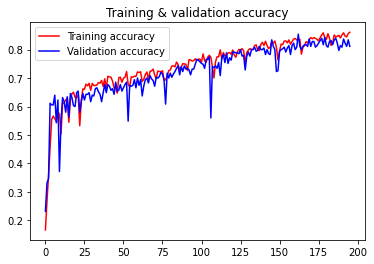

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
import numpy as np
# Plot the results
acc = np.concatenate((acc,history.history['accuracy']), axis=0)
val_acc = np.concatenate((val_acc,history.history['val_accuracy']), axis=0)

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [11]:
import pathlib
import tensorflow as tf
export_dir = './saved_model/4'
tf.saved_model.save(model, export_dir)

mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT
    
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.optimizations = [optimization]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./76acc75val_conv7class.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: ./saved_model/4\assets


INFO:tensorflow:Assets written to: ./saved_model/4\assets


1789648

In [15]:
history = model.fit(train_data_gen, 
                    epochs=100, 
                    validation_data = val_data_gen, 
                    verbose = 1,
                    callbacks = [callbacks]
                   )

Epoch 1/100
40/40 [==============================] - 188s 5s/step - loss: 0.5228 - accuracy: 0.7563 - val_loss: 0.5089 - val_accuracy: 0.7514
Epoch 2/100
40/40 [==============================] - 182s 5s/step - loss: 0.4896 - accuracy: 0.7848 - val_loss: 0.5594 - val_accuracy: 0.7486
Epoch 3/100
40/40 [==============================] - 181s 4s/step - loss: 0.5208 - accuracy: 0.7602 - val_loss: 0.6883 - val_accuracy: 0.7343
Epoch 4/100
40/40 [==============================] - 188s 5s/step - loss: 0.5492 - accuracy: 0.7563 - val_loss: 0.5886 - val_accuracy: 0.7657
Epoch 5/100
40/40 [==============================] - 187s 5s/step - loss: 0.4853 - accuracy: 0.7737 - val_loss: 0.5260 - val_accuracy: 0.7657
Epoch 6/100
40/40 [==============================] - 190s 5s/step - loss: 0.4874 - accuracy: 0.7801 - val_loss: 0.4954 - val_accuracy: 0.7743
Epoch 7/100
40/40 [==============================] - 193s 5s/step - loss: 0.5269 - accuracy: 0.7729 - val_loss: 2.0906 - val_accuracy: 0.5600
Epoch 

In [16]:
import pathlib
import tensorflow as tf
export_dir = './savedmodel'
tf.saved_model.save(model, export_dir)

mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT
    
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.optimizations = [optimization]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./82-83-7ClassRiceLeaf.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: ./saved_model/5\assets


INFO:tensorflow:Assets written to: ./saved_model/5\assets


1789648

In [20]:
history = model.fit(train_data_gen, 
                    epochs=50, 
                    validation_data = val_data_gen, 
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/50
40/40 [==============================] - 195s 5s/step - loss: 0.4306 - accuracy: 0.8229 - val_loss: 0.4219 - val_accuracy: 0.8114
Epoch 2/50
40/40 [==============================] - 181s 5s/step - loss: 0.3902 - accuracy: 0.8301 - val_loss: 0.4385 - val_accuracy: 0.8000
Epoch 3/50
40/40 [==============================] - 186s 5s/step - loss: 0.4765 - accuracy: 0.8079 - val_loss: 0.6172 - val_accuracy: 0.7229
Epoch 4/50
40/40 [==============================] - 180s 4s/step - loss: 0.5635 - accuracy: 0.7634 - val_loss: 0.6147 - val_accuracy: 0.7257
Epoch 5/50
40/40 [==============================] - 184s 5s/step - loss: 0.4977 - accuracy: 0.7952 - val_loss: 0.4233 - val_accuracy: 0.7943
Epoch 6/50
40/40 [==============================] - 189s 5s/step - loss: 0.4213 - accuracy: 0.8194 - val_loss: 0.4328 - val_accuracy: 0.8000
Epoch 7/50
40/40 [==============================] - 187s 5s/step - loss: 0.4145 - accuracy: 0.8174 - val_loss: 0.4312 - val_accuracy: 0.8029
Epoch 8/50
40